# TC 5033
## Deep Learning
## Fully Connected Deep Neural Networks

#### Activity 1b: Implementing a Fully Connected Network for Kaggle ASL Dataset

- Objective

The aim of this part of the activity is to apply your understanding of Fully Connected Networks by implementing a multilayer network for the [Kaggle ASL (American Sign Language) dataset](https://www.kaggle.com/datasets/grassknoted/asl-alphabet). While you have been provided with a complete solution for a Fully Connected Network using Numpy for the MNIST dataset, you are encouraged to try to come up with the solution.

- Instructions

    This activity requires submission in teams of 3 or 4 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Load and Preprocess Data: You are provided a starter code to load the data. Be sure to understand the code.

    Review MNIST Notebook (Optional): Before diving into this activity, you have the option to revisit the MNIST example to refresh your understanding of how to build a Fully Connected Network using Numpy.

    Start Fresh: Although you can refer to the MNIST solution at any point, try to implement the network for the ASL dataset on your own. This will reinforce your learning and understanding of the architecture and mathematics involved.

    Implement Forward and Backward Pass: Write the code to perform the forward and backward passes, keeping in mind the specific challenges and characteristics of the ASL dataset.
    
     Design the Network: Create the architecture of the Fully Connected Network tailored for the ASL dataset. Choose the number of hidden layers, neurons, and hyperparameters judiciously.

    Train the Model: Execute the training loop, ensuring to track performance metrics such as loss and accuracy.

    Analyze and Document: Use Markdown cells to document in detail the choices you made in terms of architecture and hyperparameters, you may use figures, equations, etc to aid in your explanations. Include any metrics that help justify these choices and discuss the model's performance.  

- Evaluation Criteria

    - Code Readability and Comments
    - Appropriateness of chosen architecture and hyperparameters for the ASL dataset
    - Performance of the model on the ASL dataset (at least 70% acc)
    - Quality of Markdown documentation

- Submission

Submit this Jupyter Notebook in canvas with your complete solution, ensuring your code is well-commented and includes Markdown cells that explain your design choices, results, and any challenges you encountered.


In [1]:
# import required libraries
import numpy as np
import string
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
import os

%load_ext autoreload
%autoreload 2
#################################
%matplotlib inline

In [2]:
# Load the data
DATA_PATH = './asl_data'
train_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_train.csv'))   # train data
valid_df = pd.read_csv(os.path.join(DATA_PATH, 'sign_mnist_valid.csv'))   # validation data

In [3]:
# review the first 5 rows of the train data 
train_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,12,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


### Import Images

The following code removes the label column from the data and converts the data into numpy arrays:

In [4]:
y_train = np.array(train_df['label'])   # training data labels
y_val = np.array(valid_df['label'])     # validation data labels

del train_df['label']                   # remove the label column from the train data
del valid_df['label']                   # remove the label column from the validation data

x_train = train_df.values.astype(np.float32)    # convert the train data to a numpy array
x_val = valid_df.values.astype(np.float32)      # convert the validation data to a numpy array

Next, we create a function that will split the validation test into a validation set and a test set. We will use the validation set to tune the hyperparameters and the test set to evaluate the model's performance.

In [5]:
def split_val_test(x, y, pct=0.5, shuffle=True):
    '''
    This function splits the previously loaded validation set into valition and test sets.
    args: x: numpy array of images
          y: numpy array of labels
          pct: percentage of data to be used for validation
          shuffle: whether to shuffle the data before splitting
    '''
    if shuffle:
        idx = np.arange(len(x))     # create an array of indices
        np.random.shuffle(idx)      # shuffle the indices
        x = x[idx]                  # shuffle the array of images
        y = y[idx]                  # shuffle the array of labels
    # split the images and labels into training and validation sets
    return x[:int(len(x)*pct)], y[:int(len(y)*pct)], x[int(len(x)*pct):], y[int(len(y)*pct):]

In [6]:
# Split validation set into validation and test
x_val, y_val, x_test, y_test = split_val_test(x_val, y_val)

After splitting the data, we now verify that the shape of the training, validation, and test sets are correct:

In [7]:
print(f'Training set: {x_train.shape, y_train.shape}')
print(f'Validation set: {x_val.shape, y_val.shape}')
print(f'Test set: {x_test.shape, y_test.shape}')

Training set: ((27455, 784), (27455,))
Validation set: ((3586, 784), (3586,))
Test set: ((3586, 784), (3586,))


The following code is checks the number of unique labels in the dataset:

In [8]:
alphabet=list(string.ascii_lowercase)  # create a list of all the alphabets
alphabet.remove('j')                   # remove the letter j from the list
alphabet.remove('z')                   # remove the letter z from the list

print(len(alphabet))

24


### Data Normalization

The following function normalizes the data by calculating the **Z-score:**

In [9]:
# Data normalization Z-score
def normalise(x_mean, x_std, x_data):
    '''
    This function returns the Z-score of the input data.
    args: x_mean: mean of the input data
          x_std: standard deviation of the input data
          x_data: input data
    '''
    return (x_data - x_mean) / x_std

In [10]:
x_mean = np.mean(x_train)   # calculate the mean of the training set
x_std = np.std(x_train)     # calculate the standard deviation of the training set

x_train = normalise(x_mean, x_std, x_train)     # normalize the training set
x_val = normalise(x_mean, x_std, x_val)         # normalize the validation set
x_test = normalise(x_mean, x_std, x_test)       # normalize the test set

After normalizing the data, we should have a mean of 0 and a standard deviation of 1:

In [11]:
# Check the mean and standard deviation of the normalized training set
x_train.mean(), x_train.std()

(3.6268384e-06, 0.99999946)

### Plot sample images

The following function plots sample images from the dataset:

In [12]:
def plot_alphabet(image):
    '''
    This function plots the image of the alphabet list
    args: image: image to be plotted
    '''
    plt.imshow(image.reshape(28,28), cmap='gray')   # reshape the image to 28x28 and plot it
    plt.axis('off')
    plt.show()

Let's now plot random images:

This image belongs to the letter n


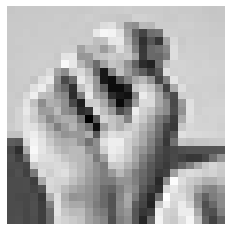

In [13]:
rnd_idx = np.random.randint(len(y_test))   # create a random index

print(f'This image belongs to the letter {alphabet[y_test[rnd_idx]]}')
plot_alphabet(x_test[rnd_idx])

### Equations for our model:


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$

### Additional Functions

#### Mini batches

In order to avoid memory issues during training, we will split the training data into mini-batches. The following function creates mini-batches:

In [14]:
# mini-batch generator
def minibatch(mb_size, x, y, shuffle=True):
    '''
    This function creates the mini-batches.
    args: mb_size: mini-batch size
          x: numpy array of images
          y: numpy array of labels
          shuffle: whether to shuffle the data before splitting
    '''
    assert x.shape[0] == y.shape[0], 'Sample Qty. Error'    # check if the number of images and labels are equal
    total_data = x.shape[0]                                 # get the total number of data

    if shuffle:
        idxs = np.arange(total_data)        # create an array of indices
        np.random.shuffle(idxs)             # shuffle the indices
        x = x[idxs]                         # shuffle the array of images
        y = y[idxs]                         # shuffle the array of labels
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))   # return the mini-batch

## Linear, ReLU and Sequential Classes

In [15]:
# This class creates a tensor from a numpy array
class np_tensor(np.ndarray): pass  

### Linear Class

The `Linear()` class initializes the weights and biases for each layer. The forward pass is implemented using the `__call__` function. The `backward` function performs the backward pass.

In [17]:
class Linear():
    def __init__(self, input_size, output_size):
        '''
        This function initializes the parameters using Kaiming He initialization
        args: input_size: number of input features
              output_size: number of output features    
        '''
        self.W = (np.random.randn(output_size, input_size) / np.sqrt(input_size/2)).view(np_tensor)  # initialize the weights using Kaiming He
        self.b = (np.zeros((output_size, 1))).view(np_tensor)                                        # initialize the biases as zeros
    
    def __call__(self, X):
        '''
        This function performs the forward pass of the linear layer
        args: X: input data
        '''
        Z = self.W @ X + self.b         # calculate the linear transformation
        return Z
    
    def backward(self, X, Z):
        '''
        This function performs the backward pass of the linear layer
        args: X: input data
              Z: output data of the forward pass
        '''
        X.grad = self.W.T @ Z.grad                              # calculate the gradients of the inputs    
        self.W.grad = Z.grad @ X.T                              # calculate the gradients of the weights
        self.b.grad = np.sum(Z.grad, axis=1, keepdims=True)     # sum the gradients of the biases

### ReLU Class

For the `ReLU()` class we also implement the forward and backward passes, using the `__call__` and `backward` functions respectively.

In [18]:
class ReLU():
    def __call__(self, Z):
        '''
        This function performs the ReLU activation
        args: Z: input data from the previous linear layer
        '''
        return np.maximum(0, Z)     # Returns zero if the input is negative or the input itself if it is positive
    
    def backward(self, Z, A):
        '''
        This function performs the backward pass of the ReLU activation function
        args: Z: input data from the previous linear layer
              A: output data of the ReLU activation function
        ''' 
        Z.grad = A.grad.copy()      # Backward pass of the ReLU activation function
        Z.grad[Z <= 0] = 0          # Set the gradients to zero where the inputs are negative

### Sequential Class

The `Sequential_layers()` class is a container for the neural network layers. It is used to stack the layers in the order defined by the user. The `__call__` function is used to perform the forward pass. The `backward` function is used to perform the backward pass. Weights and biases are updated using the `update` function, and the `predict` function returns the predicted class label.

In [19]:
class Sequential_layers():
    def __init__(self, layers):
        '''
        This function initializes the layers
        args: layers: list of layers
        '''
        self.layers = layers    # initialize the layers
        self.x = None           # initialize the input
        self.outputs = {}       # initialize the outputs
   
    def __call__(self, X):
        '''
        This function performs the forward pass of the network
        args: X: input data
        '''
        self.x = X                                      # set the input of the first layer
        self.outputs['l0'] = self.x                     # set the output of the first layer
        for i, layer in enumerate(self.layers, 1):      # loop through the layers
            self.x = layer(self.x)                      # forward pass for each layer
            self.outputs['l'+str(i)] = self.x           # set the output of each layer
        return self.x
   
    def backward(self):
        '''
        This function performs the backward pass of the network
        '''
        for i in reversed(range(len(self.layers))):                                         # loop through the layers in reverse order
            self.layers[i].backward(self.outputs['l'+str(i)], self.outputs['l'+str(i+1)])   # backward pass for each layer
    
    def update(self, learning_rate = 1e-3):
        '''
        This function updates the weights and biases of the network
        args: learning_rate: learning rate or step size
        '''
        for layer in self.layers:
            if isinstance(layer, ReLU): continue                # skip the ReLU layer
            layer.W = layer.W - learning_rate * layer.W.grad    # update the weights
            layer.b = layer.b - learning_rate * layer.b.grad    # update the biases
    
    def predict(self, X):
        '''
        This function predicts the class of the input
        args: X: input data
        '''
        return np.argmax(self.__call__(X))      # return the predicted class   

### Cost Function

We will use the **Softmax** function to calculate the probabilities of each class. The **cross-entropy** loss is then computed using the predicted probabilities and the actual labels.

In [20]:
def softmaxXEntropy(x, y):
    '''
    This function computes the softmax and cross-entropy loss
    args: x: numpy array of scores
          y: numpy array of labels
    '''
    batch_size = x.shape[1]         # get the batch size
    exp_scores = np.exp(x)          # calculate the exponential of the scores
    probs = exp_scores / exp_scores.sum(axis=0)   # calculate the softmax probabilities
    preds = probs.copy()                          # make a copy of the probabilities

    y_hat = probs[y.squeeze(), np.arange(batch_size)]  # get the probabilities of the correct class
    cost = np.sum(-np.log(y_hat)) / batch_size         # calculate the cross-entropy loss for the batch

    probs[y.squeeze(), np.arange(batch_size)] -= 1     # subtract 1 from the probabilities of the correct class
    x.grad = probs.copy()                              # define the gradients of the inputs

    return preds, cost

### Training Loop

In the training loop, we first perform the forward pass, then calculate the loss, and finally update weights and biases in the backward pass. We also calculate the accuracy of the model on the training set and the validation set. The training loop is run for the number of epochs specified by the user.   

In [21]:
def train(model, epochs, mb_size = 128, learning_rate= 1e-3):
    '''
    This function trains the model
    args: model: neural network model to be trained
          epochs: number of epochs or iterations
          mb_size: mini-batch size
          learning_rate: learning rate or step size
    '''
    for epoch in range(epochs):
        for i, (x, y) in enumerate(minibatch(mb_size, x_train, y_train)):
            scores = model(x.T.view(np_tensor))                 # calculate the scores
            _, cost = softmaxXEntropy(scores, y)
            model.backward()                                     # calculate the gradients
            model.update(learning_rate)                          # update the parameters
        print(f'Cost: {cost}, Accuracy: {accuracy(x_val, y_val, mb_size)}')   # print the cost and accuracy

The following function calculates the accuracy of the model by comparing the predicted labels with the actual labels:

In [22]:
def accuracy(x, y, mb_size):
    '''
    This function calculates the accuracy of the model
    args: x: numpy array of images
          y: numpy array of labels
          mb_size: mini-batch size
    '''
    correct = 0           
    total = 0
    for i, (x,y) in enumerate(minibatch(mb_size, x, y)):
        pred = model(x.T.view(np_tensor))                           # predict the class of the input
        correct += np.sum(np.argmax(pred, axis=0) == y.squeeze())   # calculate the number of correct predictions
        total += pred.shape[1]                                      # calculate the total number of predictions
        return correct / total                                      # return the accuracy

### Create your model and train it

#### Model architecture:

- Input layer: 784 neurons (28 x 28 images)
- Hidden layer 1: 200 neurons, ReLU activation function
- Hidden layer 2: 200 neurons, ReLU activation function
- Hidden layer 3: 200 neurons, ReLU activation function
- Output layer: 24 neurons (24 classes), Softmax activation function

Hyperparameters:

- batch size = 64
- learning rate = 1 e-4
- number of epochs = 20

Justification:

Since we have a relatively small training set (27,455 samples), we will use a small batch size of 64. We will experiment with a learning rate of 1 e-4, which is a relatively small learning rate. Our model will have 3 hidden layers with 200 neurons each, we want to avoid overfitting by having a very complex model.  Fianlly, we will train the model for 20 epochs, and our aim is to achieve an accuracy greater than 70% on the validation set.

In [23]:
model = Sequential_layers([Linear(784, 200), ReLU(), 
                           Linear(200, 200), ReLU(),
                           Linear(200, 200), ReLU(), 
                           Linear(200, 200), ReLU(), 
                           Linear(200, 24)
                          ])    
mb_size = 64
learning_rate = 1e-4
epochs = 20

We now train the model using our `train` function: 

In [24]:
train(model, epochs, mb_size, learning_rate)

Cost: 0.8683193098926842, Accuracy: 0.59375
Cost: 0.1961563103766008, Accuracy: 0.703125
Cost: 0.0944811528936461, Accuracy: 0.65625
Cost: 0.06082201521217852, Accuracy: 0.703125
Cost: 0.038926449323169805, Accuracy: 0.8125
Cost: 0.025638386568766155, Accuracy: 0.71875
Cost: 0.016340263900647932, Accuracy: 0.75
Cost: 0.01623095192772547, Accuracy: 0.765625
Cost: 0.01981931465695581, Accuracy: 0.828125
Cost: 0.01458815289774348, Accuracy: 0.703125
Cost: 0.010911535373564402, Accuracy: 0.75
Cost: 0.011421879570158918, Accuracy: 0.75
Cost: 0.012802263575828083, Accuracy: 0.703125
Cost: 0.005164264890476534, Accuracy: 0.828125
Cost: 0.0056787671644060265, Accuracy: 0.859375
Cost: 0.005414499042960726, Accuracy: 0.8125
Cost: 0.005353417783073594, Accuracy: 0.703125
Cost: 0.005586048398644634, Accuracy: 0.75
Cost: 0.002852139498294403, Accuracy: 0.75
Cost: 0.003246812666432363, Accuracy: 0.828125


Calculate the accuracy of the model on the test set:

In [25]:
print(f'Accuracy: {accuracy(x_test, y_test, mb_size)}')

Accuracy: 0.796875


### Test your model on Random data from your test set

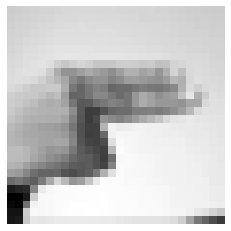

The predicted value is: h 
The actual value is: h


In [39]:
idx = np.random.randint(len(y_test))                # create a random index
plot_alphabet(x_test[idx].reshape(28,28))           # plot the image
pred = model.predict(x_test[idx].reshape(-1, 1))    # predict the class of the image

# Print the test image, predicted value and actual value
print(f'The predicted value is: {alphabet[pred]} \nThe actual value is: {alphabet[y_test[idx]]}')